In [83]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob

# Step 1: Calibrating the camera

In [84]:
#Calibrating The camera
def CalibrateCamera():
    image_files = glob.glob('camera_cal/calibration*.jpg')
    objpoints = []  
    imgpoints = []  
    objp=np.zeros((6*9,3),np.float32)
    objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

    for fname in image_files:
        img=mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret==True:
            objpoints.append(objp)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    #DEBUGGING
    #plotCameraCorrection(mtx, dist)

    return mtx, dist

#Check the results by correcting chessboard patterns
def plotCameraCorrection(mtx, dist):
    image_files = glob.glob('camera_cal/calibration*.jpg')
    for fname in image_files:
        img=mpimg.imread(fname)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        plt.figure(figsize = (16,16))
        plt.imshow(img)
        plt.show()
        plt.figure(figsize = (16,16))
        plt.imshow(dst)
        plt.show()
        print("New Img")

# Step 2: Appying Sobel and HLS Thresholding

In [85]:
#Apply Thresholding
def Thresholding(img):
    #SOBEL Thresholding
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #gray = img[:,:,1]
    
    kernelSize=3
    #pad=np.int_((kernelSize-1)/2)
    #Pad image
    #gray = cv2.copyMakeBorder( gray, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=(255,255,255))
    xImg=abs_sobel_thresh(gray, 'x', kernelSize, (30, 200))
    yImg=abs_sobel_thresh(gray, 'y', kernelSize, (30, 200))
    magImg=mag_thresh(gray, kernelSize, (30, 200))
    dirImg=dir_threshold(gray, kernelSize, (0.7, 1.3))
    sobelThresh=np.zeros_like(gray).astype(np.uint8)
    sobelThresh[((xImg == 1) & (magImg == 1) & (dirImg == 1)) | ((xImg == 1) & (yImg == 1))] = 1
    #sobelThresh=sobelThresh[pad:-pad,pad:-pad]
    
    #HLS Thresholding
    hlsThresh=hls_thresh(img, (150, 255))
    
    #Combine Sobel and HLS
    final=combine_sobel_hls_thresh(sobelThresh, hlsThresh)
    
    #DEBUGGING
    #testThresholding(xImg,yImg,magImg,dirImg)
    #plotThresholding(xImg,yImg,magImg,dirImg,sobelThresh,hlsThresh,final)
    
    return final
    

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output
    
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

def hls_thresh(img, thresh=(80, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary = np.zeros_like(s_channel)
    binary[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary
    
def combine_sobel_hls_thresh(sobel, hls):
    result = np.zeros_like(hls).astype(np.uint8)
    result[((sobel == 1) | (hls == 1))] = 1
    return result

def plotThresholding(xImg,yImg,magImg,dirImg,sobelThresh,hlsThresh,final):
    plt.figure(figsize = (16,16))
    plt.imshow(xImg,cmap='gray')
    plt.title('X-dirn Sobel')
    plt.show()
    plt.figure(figsize = (16,16))
    plt.imshow(yImg,cmap='gray')
    plt.title('Y-dirn Sobel')
    plt.show()
    plt.figure(figsize = (16,16))
    plt.imshow(magImg,cmap='gray')
    plt.title('mag Sobel')
    plt.show()
    plt.figure(figsize = (16,16))
    plt.imshow(dirImg,cmap='gray')
    plt.title('custom-dirn Sobel')
    plt.show()
    plt.figure(figsize = (16,16))
    plt.imshow(sobelThresh,cmap='gray')
    plt.title('Combined Sobel')
    plt.show()
    plt.figure(figsize = (16,16))
    plt.imshow(hlsThresh,cmap='gray')
    plt.title('HLS')
    plt.show()
    plt.figure(figsize = (16,16))
    plt.imshow(final,cmap='gray')
    plt.title('Final')
    plt.show()

def testThresholding(xImg,yImg,magImg,dirImg):
    sobelThresh=np.zeros_like(xImg).astype(np.uint8)
    sobelThresh[((xImg == 1) & (magImg == 1) & (dirImg == 1))] = 1
    plt.figure(figsize = (16,16))
    plt.imshow(sobelThresh,cmap='gray')
    plt.title('X-dirn')
    plt.show()
    
    sobelThresh[((yImg == 1) & (magImg == 1) & (dirImg == 1))] = 1
    plt.figure(figsize = (16,16))
    plt.imshow(sobelThresh,cmap='gray')
    plt.title('Y-dirn')
    
    sobelThresh[((xImg == 1) & (magImg == 1) & (dirImg == 1))|((yImg == 1) & (magImg == 1) & (dirImg == 1))] = 1
    plt.figure(figsize = (16,16))
    plt.imshow(sobelThresh,cmap='gray')
    plt.title('X or Y-dirn')
    
    sobelThresh[((xImg == 1) & (magImg == 1) & (dirImg == 1)) | ((xImg == 1) & (yImg == 1))] = 1
    plt.figure(figsize = (16,16))
    plt.imshow(sobelThresh,cmap='gray')
    plt.title('X or X with Y')
    

# Step 3: Applying Prespective transformation to get a Birds-eye view

In [86]:
#Apply Prespective Transform
def prespective(img):
    init_left_top=(.468*img.shape[1],.62*img.shape[0])
    init_right_top=(.533*img.shape[1],.62*img.shape[0])
    init_left_bottom=(.16*img.shape[1],1.0*img.shape[0])
    init_right_bottom=(.863*img.shape[1],1.0*img.shape[0])
    
    #lanes at 200 and 800 px for 1280px length
    final_left_top=(.153*img.shape[1],.1*img.shape[0])
    final_right_top=(.615*img.shape[1],.1*img.shape[0])
    final_left_bottom=(.153*img.shape[1],1.0*img.shape[0])
    final_right_bottom=(.615*img.shape[1],1.0*img.shape[0])
    
    src=np.float32([init_left_bottom,init_left_top,init_right_top,init_right_bottom])
    dst=np.float32([final_left_bottom, final_left_top, final_right_top, final_right_bottom])
        
    prespImg= PrespectiveTrans(img,src,dst)
    #Trim x to 1000px for 1280px length
    prespImg=prespImg[:,0:np.int_(.77*img.shape[1])]
    
    #DEBUGGING
    #plotPrespective(img,src,dst)

    return prespImg, src, dst
    
def PrespectiveTrans(img,src,dst):
    M = cv2.getPerspectiveTransform(src, dst)
    img_size=(img.shape[1],img.shape[0])
    prespImg = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return prespImg
    
def plotPrespective(img,src,dst):
    #print(src)
    #print(dst)
    if img.ndim!=3:
        #For single channel Binary images
        r,c=img.shape
        imgDebug= np.zeros((r,c,3),dtype=np.uint8)
        imgDebug[:,:,0]=img
        imgDebug[(imgDebug>0)]=255
    else:
        imgDebug=img
    prespDebug= PrespectiveTrans(imgDebug,src,dst)
    prespDebug=prespDebug[:,0:np.int_(.77*img.shape[1])]
    
    cv2.line(imgDebug,tuple(np.int_(src[0])), tuple(np.int_(src[1])),(255,255,255),5)
    cv2.line(imgDebug,tuple(np.int_(src[2])), tuple(np.int_(src[3])),(255,255,255),5)
    cv2.line(prespDebug,tuple(np.int_(dst[0])), tuple(np.int_(dst[1])),(255,255,255),5)
    cv2.line(prespDebug,tuple(np.int_(dst[2])), tuple(np.int_(dst[3])),(255,255,255),5)
    plt.figure(figsize = (16,16))
    plt.imshow(imgDebug)
    plt.show()
    plt.figure(figsize = (16,16))
    plt.imshow(prespDebug)
    plt.show()

# Step 4: Finding Left and Right Lane curves

In [98]:
# Find lane line polonomial curves
def find_lane_pixels(img, visualWindow=True):
    img[(img==1)]=255
    
    #Approximate the base of left and right lane
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = int(.08*img.shape[1]) #80px for 1000px width
    # Set minimum number of pixels found to recenter window
    minpix = int(.008*margin**2 )#50 px for 1000px width

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        # Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if visualWindow:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window 
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

# Step 5: Computing Left and Right Lane curves

In [96]:
def fit_polynomial_new(binary_warped, Left_lane, Right_lane):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, num=binary_warped.shape[0] )
    print(ploty)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Update Lane classes
    Left_lane.detected, Right_lane.detected= True, True
    Left_lane.poly_coff, Right_lane.poly_coff = left_fit, right_fit  
    Left_lane.yCoord, Right_lane.yCoord= ploty, ploty
    Left_lane.xCoord, Right_lane.xCoord= left_fitx, right_fitx

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    out_img_lanepx=np.zeros_like(out_img) #Copy with only lane pixels
    out_img_lanepx[lefty, leftx] = [255, 0, 0]
    out_img_lanepx[righty, rightx] = [0, 0, 255]
    
    # Plot lane
    laneLayer= np.zeros_like(out_img)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(laneLayer,np.int_([lane_pts]),[0,255,0])
    
    #Combine both images
    out_img_lanepx=cv2.addWeighted(out_img_lanepx, 1, laneLayer, .2, 0)

    return out_img, out_img_lanepx
    

In [89]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients averaged over the last n iterations
        self.poly_coff = None  
        # y values of plotted line
        self.yCoord= None
        # x values for plotted line
        self.xCoord= None

# Step 5: Finding the Lane curvature

In [99]:
def measure_curvature_pixels(img, ploty, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    lane_width_px=600/1000*img.shape[1]    #600px when total image width was 1000px
    lane_ht_px=620/720*img.shape[0]        #620px when total image ht was 720px
    
    ym_per_pix = 40/lane_ht_px # meters per pixel in y dimension
    xm_per_pix = 3.7/lane_width_px # meters per pixel in x dimension
        
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Implement the calculation of R_curve (radius of curvature) #####
    left_fit_poly=np.polyfit(ploty, left_fit, 2)
    right_fit_poly=np.polyfit(ploty, right_fit, 2)
    left_curverad = ((1 + (2*left_fit_poly[0]*y_eval*ym_per_pix + left_fit_poly[1])**2)**1.5) / np.absolute(2*left_fit_poly[0])
    right_curverad = ((1 + (2*right_fit_poly[0]*y_eval*ym_per_pix + right_fit_poly[1])**2)**1.5) / np.absolute(2*right_fit_poly[0])
    curv=(left_curverad + right_curverad)/2
    
    curv_msg="Lane curvature is "+ str(round(curv))+ "m"
    
    return curv_msg

def measure_location_in_lane(img, ploty, left_fit, right_fit):
    y_eval = ploty[-1]
    x_l=left_fit[-1]
    x_r=right_fit[-1]
    lane_mid=int((x_l+x_r)/2)
    car_loc=int(img.shape[1]/2)
    loc=lane_mid-car_loc
    
    lane_width_px=600/1000*img.shape[1]    #600px when total image width was 1000px
    xm_per_pix = 3.7/lane_width_px         # meters per pixel in x dimension
    offset=np.abs(loc)*xm_per_pix
    loc_msg=""
    if loc>0:
        loc_msg="Car's distance from centre is "+ str(round(offset,1)) +"m Left"
    elif loc<0:
        loc_msg="Car's distance from centre is "+ str(round(offset,1)) +"m Right"
    else:
        loc_msg="Car is in centre of lane"
    
    return loc_msg

# Step 6: Creating Visualization for each Frame

In [91]:
def visualize(undistorted,lanepxImg,dst,src,y,lx,rx):
    #Create lane lines over original image
    invPresImg=cv2.copyMakeBorder(lanepxImg, 0, 0, 0, undistorted.shape[1]-lanepxImg.shape[1], cv2.BORDER_CONSTANT, value=(0,0,0))
    invPresImg=PrespectiveTrans(invPresImg,dst,src)    
    FinalImg=cv2.addWeighted(undistorted, .7, invPresImg, 1, 0)
    
    curv_msg= measure_curvature_pixels(y, lx, rx)
    loc_msg= measure_location_in_lane(y, lx, rx)
    
    cv2.putText(FinalImg, curv_msg, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    cv2.putText(FinalImg, loc_msg, (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    
    return FinalImg
    
    

# Process Pipeline for each frame

In [100]:
#Pipeline for each frame
def pipeline(img, Left_lane, Right_lane):
    #img=cv2.resize(img, None, fx=1 / 2, fy=1 / 2, interpolation=cv2.INTER_AREA)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    threshImg = Thresholding(undistorted)
    prespImg, src,dst = prespective(threshImg)
    
    if (Left_lane.detected==False):
        laneImg,lanepxImg = fit_polynomial_new(prespImg, Left_lane, Right_lane)
    else:
        laneImg,lanepxImg = search_around_poly(prespImg,Left_lane, Right_lane)
    
    FinalImg=visualize(undistorted,lanepxImg,dst,src,Left_lane.yCoord,Left_lane.xCoord,Right_lane.xCoord)
    
    
    debug=1
    if debug==1:
        plt.imshow(img)
        plt.show()
        cv2.imwrite('./output_images/0_original.png',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        
        plt.imshow(undistorted)
        plt.show()
        cv2.imwrite('./output_images/1_undistorted.png',cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR))
        
        plt.imshow(threshImg,cmap='gray')
        threshImg=threshImg*255
        plt.show()
        cv2.imwrite('./output_images/2_threshImg.png',threshImg)
        
        plt.imshow(prespImg,cmap='gray')
        plt.show()
        cv2.imwrite('./output_images/3_birdsEyeImg.png',prespImg)
        
        fig = plt.figure()
        plt.imshow(laneImg)
        plt.plot(Left_lane.xCoord, Left_lane.yCoord, color='yellow')
        plt.plot(Right_lane.xCoord, Right_lane.yCoord, color='yellow')
        plt.show()
        fig.savefig('output_images/4_laneImg.png')
        #cv2.imwrite('./debug/img.png',cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
        
        plt.imshow(FinalImg)
        plt.show()
        cv2.imwrite('./output_images/5_FinalVisualImg.png',cv2.cvtColor(FinalImg, cv2.COLOR_RGB2BGR))
    
    return FinalImg
        



# Code to process an Image

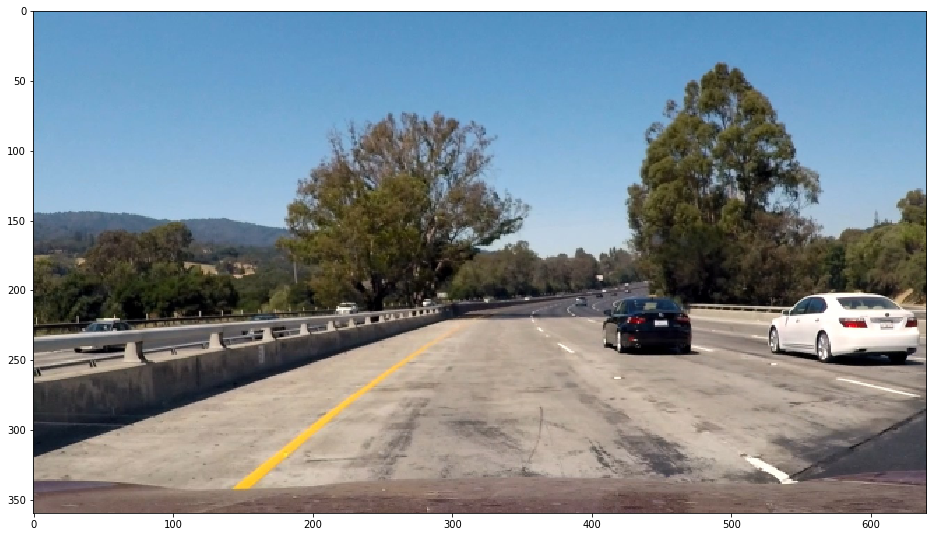

(360, 640)


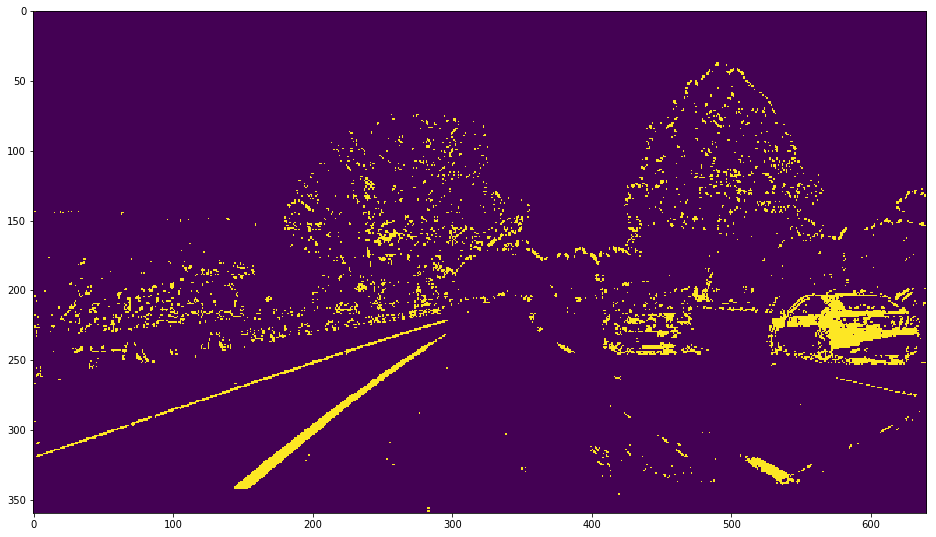

(360, 492)


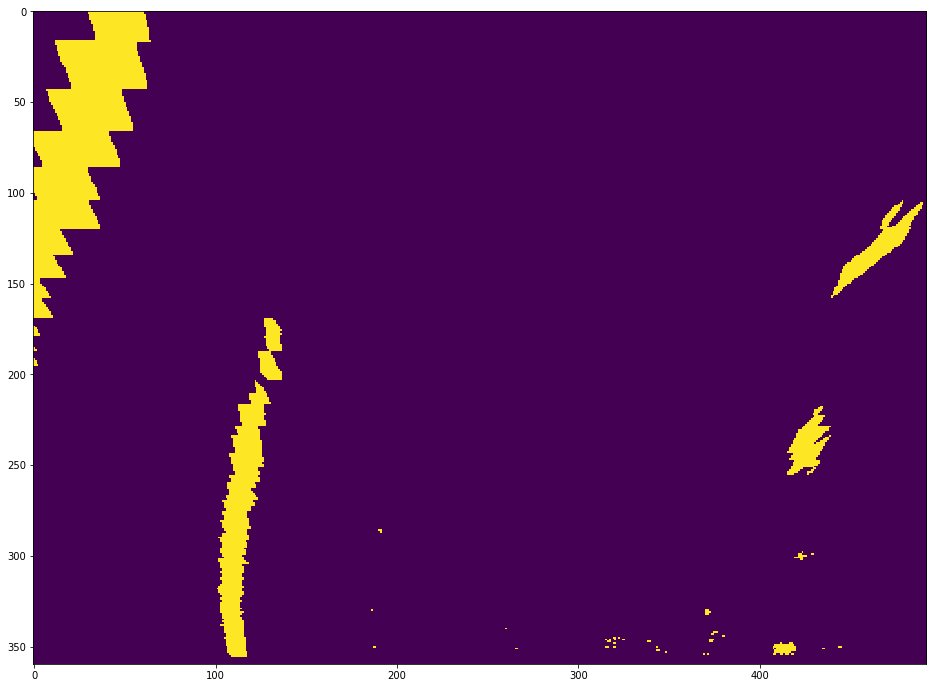

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

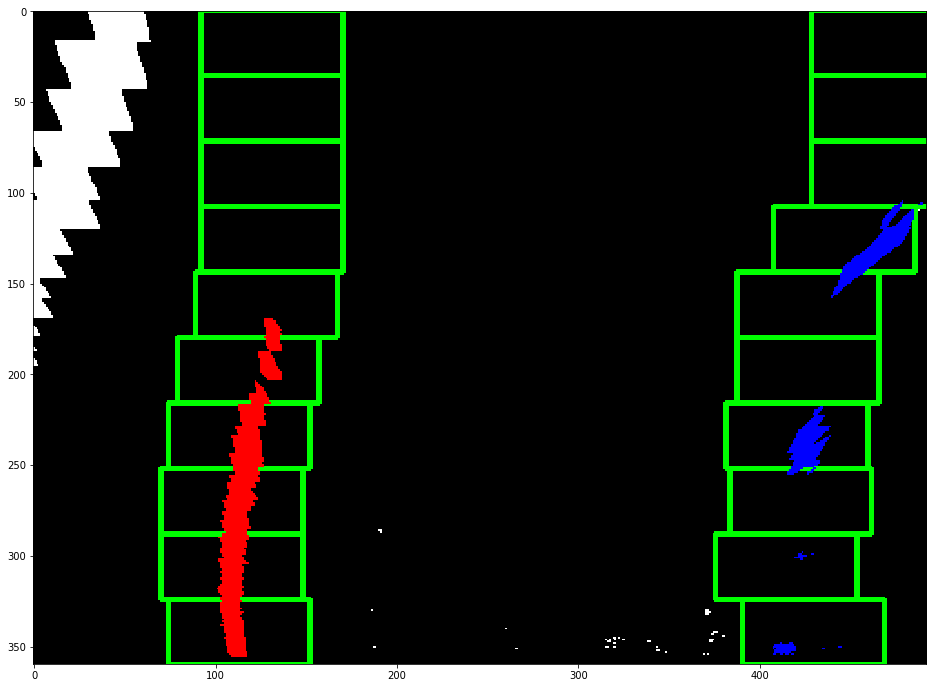

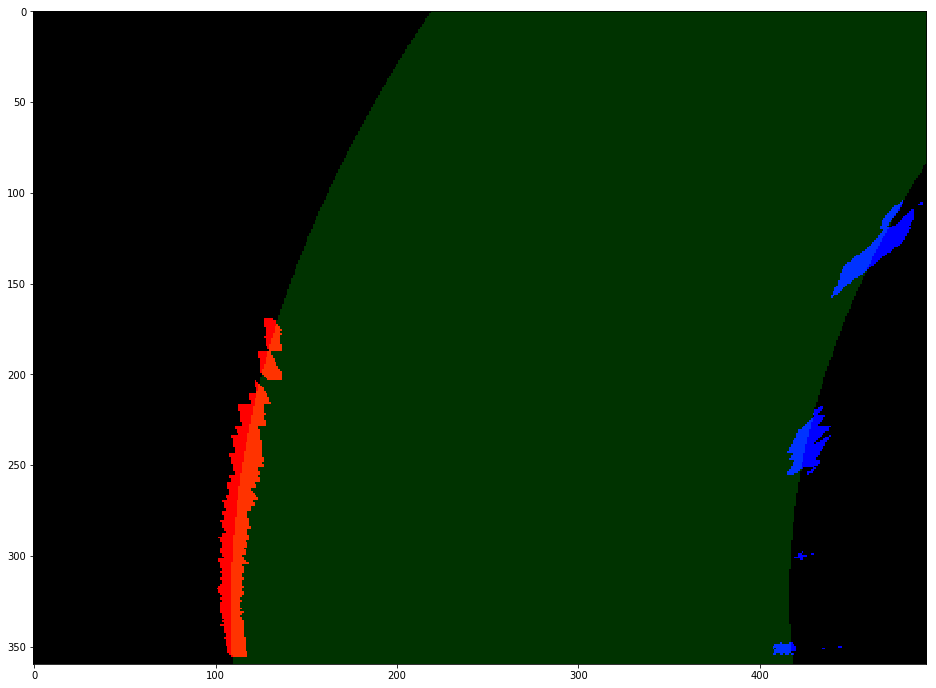

In [101]:
img=mpimg.imread('test_images/test1.jpg')
x=360;y=640;
img=cv2.resize(img,(y,x)) 
plt.figure(figsize = (16,16))
plt.imshow(img)
plt.show()
        

threshImg = Thresholding(img)
print(threshImg.shape)
plt.figure(figsize = (16,16))
plt.imshow(threshImg)
plt.show()

pres,_,_ = prespective(threshImg)
print(pres.shape)
plt.figure(figsize = (16,16))
plt.imshow(pres)
plt.show()


Left_lane=Line()
Right_lane=Line()
laneImg,lanepxImg = fit_polynomial_new(pres, Left_lane, Right_lane)
plt.figure(figsize = (16,16))
plt.imshow(laneImg)
plt.show()

plt.figure(figsize = (16,16))
plt.imshow(lanepxImg)
plt.show()


In [46]:
# Import the required modules
import cv2
import numpy as np
from IPython.display import clear_output, display, Image
import PIL.Image
from io import BytesIO
import ipywidgets as widgets

def img2ByteArr(frame, ext='jpeg'):
    byteObj = BytesIO()
    PIL.Image.fromarray(frame).save(byteObj, ext)
    return byteObj.getvalue()

cam = cv2.VideoCapture(0) #Resolutions from camera- 1920x1080, 1280x720, 640x360
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 360)
_, frame = cam.read()

#Create Ipython image widget
w=widgets.Image(value=img2ByteArr(frame));
display(w)


#print(widgets.height, widgets.width)

for frame_number in range(100):
    #Capture frame
    _, frame = cam.read()
    #print(frame.shape)
    
    #Perform operation
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    #Display frame
    w.value=img2ByteArr(frame)

cam.release()
clear_output()
#print(frame.shape)
